### Auto Encoders
Auto Encoders have a variety of image-related use-cases.
These networks can generate representations of the input, in a sort of compression.
So it learns to generate an output that approximates the original.
You can use this approximate to do all sorts of transformations on the original image.
Colorize, higher-quality, etc.

Arguably, an auto-encoder's most interesting aspect is the reverse of what we just described. When the auto-encoder receives a corrupted output and tries to reconstruct the original image from the noisy version of it.

Once we've taught an auto-encoder to remove noise from images, we can use that for a wide variety of use cases. For example we can apply it to all sorts of objects within an object element that displayed the same noise pattern,

The encoder itself encodes the input into latent space.

In [30]:
import torch
from torchvision import datasets,transforms

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

print(train_dataset)

batchSize=128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: ToTensor()


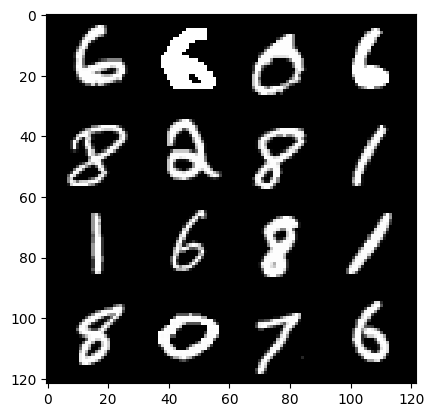

In [32]:
# Visualizing Data

import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        # decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initialzing, it will run __init__() function as above
model = Autoencoder(num_input, num_hidden_1, num_hidden_2)
# using cpu not GPU cuda
model.cpu()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

In [35]:
# Train the network
optimizer = optim.Adam(model.parameters())
epoch = 100
loss_function = nn.MSELoss()

print('====Training start====')
for i in range(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # prepare input data
        data = data.cpu()
        inputs = torch.reshape(data,(-1, 784)) # -1 can be any value. So when reshape, it will satisfy 784 first

        # set gradient to zero
        optimizer.zero_grad()

        # feed inputs into model
        recon_x = model(inputs)

        # calculating loss
        loss = loss_function(recon_x, inputs)

        # calculate gradient of each parameter
        loss.backward()
        train_loss += loss.item()

        # update the weight based on the gradient calculated
        optimizer.step()

    if i%10==0:
        print('====> Epoch: {} Average loss: {:.9f}'.format(i, train_loss ))
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 30.436954714
====> Epoch: 10 Average loss: 5.749410745
====> Epoch: 20 Average loss: 3.478483473
====> Epoch: 30 Average loss: 2.620262985
====> Epoch: 40 Average loss: 2.172454346
====> Epoch: 50 Average loss: 1.900289722
====> Epoch: 60 Average loss: 1.701865999
====> Epoch: 70 Average loss: 1.557501830
====> Epoch: 80 Average loss: 1.441567482
====> Epoch: 90 Average loss: 1.353375638
====Training finish====


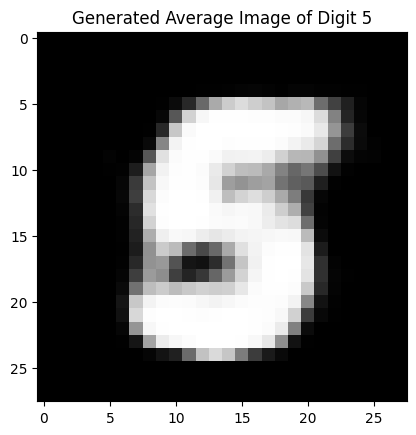

In [47]:
import torch
import matplotlib.pyplot as plt

def generate_digit(digit):

  digit_images = train_dataset.data[train_dataset.targets == digit].float()

  # Flatten images
  digit_images = torch.reshape(digit_images, (-1, 784))

  # average encoding
  encoded_digits = []
  with torch.no_grad():
      for img in digit_images:
          img = img.unsqueeze(0)
          encoded_digit = model.encoder(img)
          encoded_digits.append(encoded_digit)

  # avg of all encodes
  average_encoded_digit = torch.mean(torch.stack(encoded_digits), dim=0)

  # generate image from avg latent space
  with torch.no_grad():
      generated_image = model.decoder(average_encoded_digit)
      generated_image = generated_image.reshape(28, 28)

  return generated_image


# visualize
digit = 5 # edit to visualize any digit
generated_image = generate_digit(digit)
plt.imshow(generated_image, cmap='gray')
plt.title(f'Generated Average Image of Digit {digit}')
plt.show()

In [54]:
# get 100 image-label pairs from training set
x_train, y_train = next(iter(train_loader))

# 10 classes, 10 samples per class, 100 in total
candidates = np.random.choice(batchSize, 10*10)

# randomly select 100 samples
x_train = x_train[candidates]
y_train = y_train[candidates]

x_test, y_test = next(iter(train_loader))
candidates_test = np.random.choice(batchSize, 10*10)

x_test = x_test[candidates_test]
y_test = y_test[candidates_test]

# compute the representations of training and test samples
h_train=model.encoder(torch.reshape(x_train.cpu(),(-1,784)))
h_test=model.encoder(torch.reshape(x_test.cpu(),(-1,784)))

# find the nearest training samples to each test instance, in terms of MSE
MSEs = np.mean(np.power(np.expand_dims(h_test.detach().cpu(), axis=1) - np.expand_dims(h_train.detach().cpu(), axis=0), 2), axis=2)
neighbours = MSEs.argmin(axis=1)
predicts = y_train[neighbours]

print('Recognition accuracy according to the learned representation is %.1f%%' % (100 * (y_test == predicts).numpy().astype(np.float32).mean()))


Recognition accuracy according to the learned representation is 74.0%
